# AIzheimer: I came, I saw, I forgot

## Setup

In [1]:
!pip install diffusers transformers accelerate torchmetrics[image] torch-fidelity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 53.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [2]:
model_save_path = "unlearned_stable_diffusion"
concept_to_forget = "Elon Musk"
num_image_generate = 10
num_epochs = 40
batch_size = int(2) # must be a divisor of num_image_generate
learning_rate = 2e-5
weight_decay = 1e-3
from_images = True # use already generated images, if false sd generates images
# expected folder name is 'generated_images'
loss_selection = ["attention_resteering", "distraction", "random_stimulus"][1]
skip_first_and_last = False # if true skip the first and last cross attention module

## Prepare related model sections

In [3]:
import torch
import gc
import accelerate
from diffusers import StableDiffusionPipeline, AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from torchvision import transforms
import torch.nn.functional as F
from typing import Any
import time

# for reproducability
seed = 42
generator = torch.Generator(device="cuda").manual_seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Load the Stable Diffusion 2.1 model
model_id = "stabilityai/stable-diffusion-2-1-base"
if not from_images:
    pipe = StableDiffusionPipeline.from_pretrained(model_id)
    pipe = pipe.to("cuda")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae").to("cuda")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder").to("cuda")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.w

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

## Prepare the data

In [4]:
from os import makedirs, listdir
from os import path
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms

# Prepare the data for training
encoded_pixels = []
encoded_text = []
concept_positions = []
transform = transforms.ToTensor()


if from_images:
    # Use existing images
    image_folder = "generated_images/"
    image_files = [f for f in listdir(image_folder) if f.endswith(".jpg") or f.endswith(".png")]
    num_samples = len(image_files)

    for image_file in tqdm(image_files[:num_image_generate]):
        image_path = path.join(image_folder, image_file)
        image = Image.open(image_path)
        image = image.resize((512, 512))
        image = image.convert("RGB")
        prompt = f"a photo of {concept_to_forget}"

        image_tensor = transform(image).unsqueeze(0).to("cuda")
        pixel_values = vae.encode(image_tensor).latent_dist.sample().detach()
        encoded_pixels.append(pixel_values)
        text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
        encoded_text.append(text_input.input_ids.to("cuda"))

        concept_ids = tokenizer(concept_to_forget, add_special_tokens=False).input_ids
        prompt_ids = text_input.input_ids[0].tolist()
        positions = [1 if prompt_ids[i:i+len(concept_ids)] == concept_ids else 0 for i in range(len(prompt_ids) - len(concept_ids) + 1)]
        positions = [0] * (tokenizer.model_max_length - len(positions)) + positions
        concept_positions.append(torch.tensor(positions).unsqueeze(0))
else:
    # Generate new images
    num_samples = num_image_generate
    generated_data = []
    for _ in tqdm(range(num_samples)):
        prompt = f"a photo of {concept_to_forget}"
        image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5, generator=generator).images[0]
        generated_data.append((image, prompt))

    for image, prompt in tqdm(generated_data):
        image_tensor = transform(image).unsqueeze(0).to("cuda")
        pixel_values = vae.encode(image_tensor).latent_dist.sample().detach()
        encoded_pixels.append(pixel_values)
        text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
        encoded_text.append(text_input.input_ids.to("cuda"))

        concept_ids = tokenizer(concept_to_forget, add_special_tokens=False).input_ids
        prompt_ids = text_input.input_ids[0].tolist()
        positions = [1 if prompt_ids[i:i+len(concept_ids)] == concept_ids else 0 for i in range(len(prompt_ids) - len(concept_ids) + 1)]
        positions = [0] * (tokenizer.model_max_length - len(positions)) + positions
        concept_positions.append(torch.tensor(positions).unsqueeze(0))

    # Save the generated images
    makedirs("generated_images", exist_ok=True)
    for i, (image, prompt) in enumerate(generated_data):
        image.save(f"generated_images/{i}.png")

    del generated_data
encoded_pixels = torch.cat(encoded_pixels, dim=0)
encoded_text = torch.cat(encoded_text, dim=0)
concept_positions = torch.cat(concept_positions, dim=0).type(torch.BoolTensor).to("cuda")

  0%|          | 0/10 [00:00<?, ?it/s]

## Custom attention proceses

In [5]:
import torch
from torch import nn

class AttentionController:
    def __init__(self) -> None:
        self.attention_probabilities = []

    def __call__(self, attention_probability) -> Any:
        global batch_size

        head_count = attention_probability.shape[0] // batch_size
        target_attention = attention_probability.masked_select(
            self.concept_positions[:, None, :].repeat(head_count, 1, 1)
        ).reshape(-1, head_count, self.concept_positions[0].sum())
        self.attention_probabilities.append(target_attention)

    def set_concept_positions(self, concept_positions):
        self.concept_positions = concept_positions

    def attention_resteering_loss(self):
        flattented_attn = list()
        for attention in self.attention_probabilities:
            flattented_attn.append(attention.reshape(-1, self.concept_positions[0].sum()))
        flattented_attn = torch.cat(flattented_attn)
        return flattented_attn.norm()

    def distraction_loss(self):
        loss = torch.tensor(0, device='cuda')
        for i, attention in enumerate(self.attention_probabilities):
            desired_attention = torch.ones_like(attention) / (attention.shape[0]/batch_size)
            loss = loss + (attention - desired_attention).norm()
        return loss

    def random_stimulus_loss(self):
        loss = torch.tensor(0, device='cuda')
        for i, attention in enumerate(self.attention_probabilities):
            desired_attention = torch.rand_like(attention) / (attention.shape[0]/batch_size)
            loss = loss + (attention - desired_attention).norm()
        return loss

    def compute_loss(self, loss_type):
        if loss_type == "attention_resteering":
            return self.attention_resteering_loss()
        elif loss_type == "distraction":
            return self.distraction_loss()
        elif loss_type == "random_stimulus":
            return self.random_stimulus_loss()
        else:
            raise ValueError("Invalid loss type")

    def reset_attention_probabilities(self):
        self.attention_probabilities = []
        self.concept_positions = None


class CustomCrossAttentionProcessor:
    def __init__(self, attention_controller: "AttentionController") -> None:
        self.attention_controller = attention_controller

    def __call__(self, attention_module: "CrossAttention", hidden_states, encoder_hidden_states=None, attention_mask=None):
        batch_size, sequence_length, _ = hidden_states.shape
        attention_mask = attention_module.prepare_attention_mask(attention_mask, sequence_length, batch_size=batch_size)

        query = attention_module.to_q(hidden_states)
        query = attention_module.head_to_batch_dim(query)

        encoder_hidden_states = encoder_hidden_states if encoder_hidden_states is not None else hidden_states
        key = attention_module.to_k(encoder_hidden_states)
        value = attention_module.to_v(encoder_hidden_states)
        key = attention_module.head_to_batch_dim(key)
        value = attention_module.head_to_batch_dim(value)

        attention_probabilities = attention_module.get_attention_scores(query, key, attention_mask)
        self.attention_controller(attention_probabilities)

        hidden_states = torch.bmm(attention_probabilities, value)
        hidden_states = attention_module.batch_to_head_dim(hidden_states)

        # Linear projection
        hidden_states = attention_module.to_out[0](hidden_states)
        # Dropout
        hidden_states = attention_module.to_out[1](hidden_states)

        return hidden_states

in order to have more memory

In [6]:
# delete all the unnecesary variables and free cuda
if not from_images:
    del pipe
for i in range(10):
    time.sleep(0.1)
    gc.collect();
    torch.cuda.empty_cache()


## The main unlearning loop

100%|██████████| 40/40 [01:02<00:00,  1.56s/it]


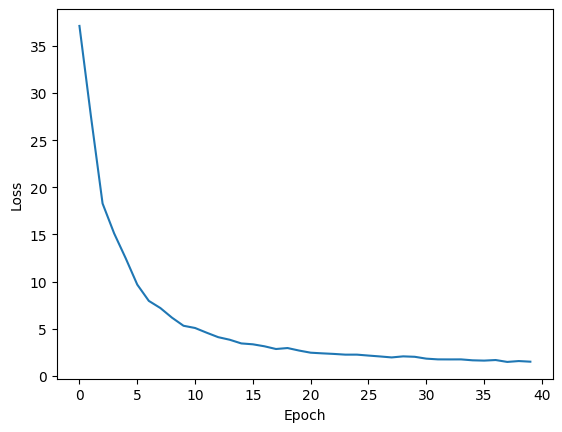

In [7]:
import itertools
from matplotlib import pyplot as plt
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Initialize the attention controller
attention_controller = AttentionController()

# Register the custom attention processor
unet.to("cuda")

# Store the default processors
default_processors = {}

cross_attention_modules = []
for name, module in unet.named_modules():
    if name.endswith('attn2'):  # attn2 is the cross attention
        cross_attention_modules.append((name, module))

# Set the cross attention processors
params_to_optimize = []
for i, (name, module) in enumerate(cross_attention_modules):
    if i == 0 or (i == len(cross_attention_modules) - 1):
        if skip_first_and_last:
            continue

    default_processors[name] = module.get_processor()
    module.set_processor(CustomCrossAttentionProcessor(attention_controller))
    params_to_optimize.append(module.parameters())

params_to_optimize = list(itertools.chain(*params_to_optimize))

unet.train()
text_encoder.eval()
vae.eval()

optimizer = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=weight_decay)

# Initialize the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)



attention_controller.set_concept_positions(concept_positions)

# Initialize the scheduler
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

loss_values = []
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    for i in range(0, len(encoded_pixels), batch_size):
        batch_pixels = encoded_pixels[i:i+batch_size]
        batch_text = encoded_text[i:i+batch_size]
        batch_concept_positions = concept_positions[i:i+batch_size]

        with torch.no_grad():
            text_embeddings = text_encoder(batch_text)[0]

        # Sample random timesteps for each image in the batch
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (batch_size,), device=batch_pixels.device).long()

        # Generate noise
        noise = torch.randn_like(batch_pixels)

        # Add noise to the latent representations according to the scheduler
        noisy_latents = scheduler.add_noise(batch_pixels, noise, timesteps)

        # Set concept positions for the current batch
        attention_controller.set_concept_positions(batch_concept_positions)

        with torch.cuda.amp.autocast():
            unet_output = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample
            loss = attention_controller.compute_loss(loss_selection)

        # Accumulate the loss for the current batch
        epoch_loss += loss.item()

        # Reset attention probabilities for the next epoch
        attention_controller.reset_attention_probabilities()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Reset attention probabilities for the next epoch
        attention_controller.reset_attention_probabilities()

    # Calculate the average loss for the epoch
    avg_epoch_loss = epoch_loss / (len(encoded_pixels) // batch_size)
    loss_values.append(avg_epoch_loss)

    # Step the learning rate scheduler
    lr_scheduler.step(avg_epoch_loss)

plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

free GPU memory

In [8]:
del text_encoder, vae, scheduler, encoded_pixels, encoded_text
for i in range(10):
    gc.collect()
    torch.cuda.empty_cache()

## Save and test the model

In [9]:
# load the model pipeline and substitude trained unet

for name, module in unet.named_modules():
    if name in default_processors: # set the default proccesors (remove custom proccesors)
        module.set_processor(default_processors[name])

unet.eval()

pipe = StableDiffusionPipeline.from_pretrained(model_id, unet=unet)

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
pipe = pipe.to("cuda")

In [11]:
# save the model on local
# pipe.save_pretrained(model_save_path)

In [12]:
from IPython.display import display


def infer_and_show(prompt, num_inference_steps=50, guidance_scale=7.5, save_image=False, save_image_path=None,
                   seed=seed, og_pipe=False, show_image=False):
    if og_pipe:
        pipeline = StableDiffusionPipeline.from_pretrained(model_id, progress_bar=False)
        pipeline = pipeline.to("cuda")
    else:
        pipeline = pipe.to("cuda")

    generator.manual_seed(seed)
    out = pipeline(prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, generator=generator)

    if save_image:
        out.images[0].save(save_image_path)

    # show the image in notebook
    if show_image:
        display(out.images[0])

    return out.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

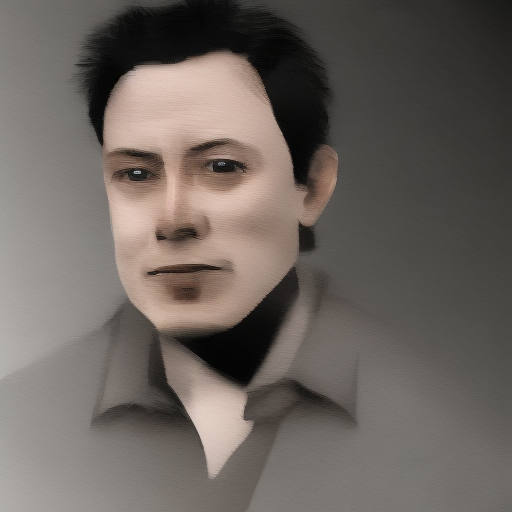

In [21]:
infer_and_show("A realistic high quality photo of Elon Musk", seed=21)

Keyword arguments {'progress_bar': False} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

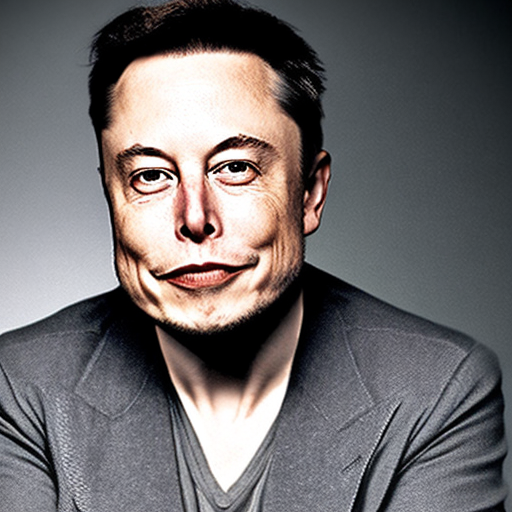

In [26]:
infer_and_show("A realistic high quality photo of Elon Musk", seed=21, og_pipe=True)

  0%|          | 0/50 [00:00<?, ?it/s]

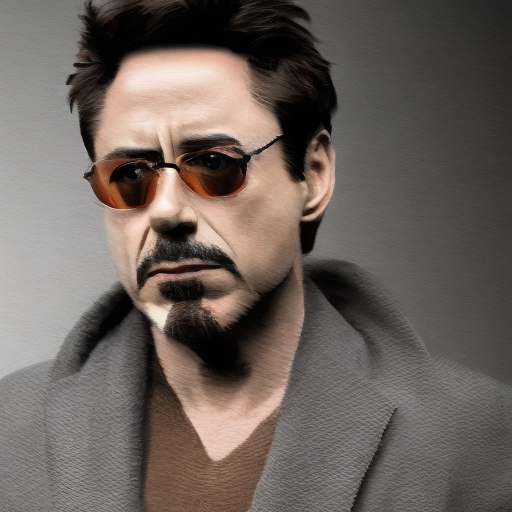

In [22]:
infer_and_show("A realistic high quality photo of Robert Downey Jr.", seed=21)

Keyword arguments {'progress_bar': False} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

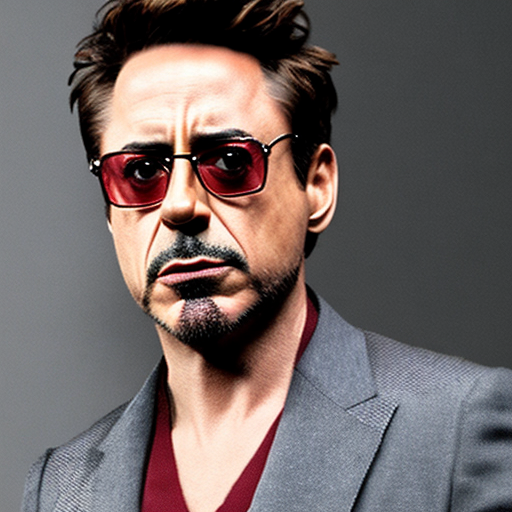

In [25]:
infer_and_show("A realistic high quality photo of Robert Downey Jr.", seed=21, og_pipe=True)

  0%|          | 0/50 [00:00<?, ?it/s]

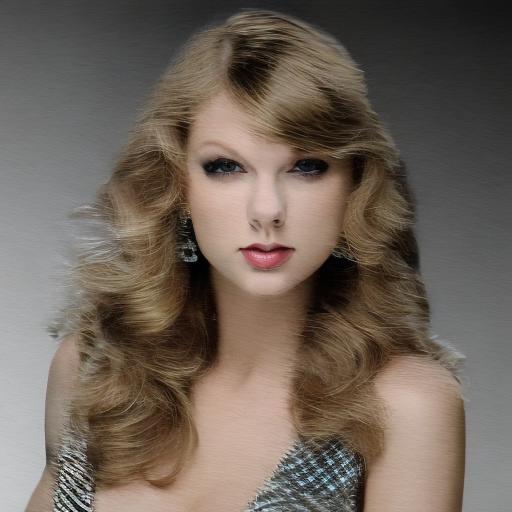

In [23]:
infer_and_show("A realistic high quality photo of taylor swift", seed=21)

Keyword arguments {'progress_bar': False} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

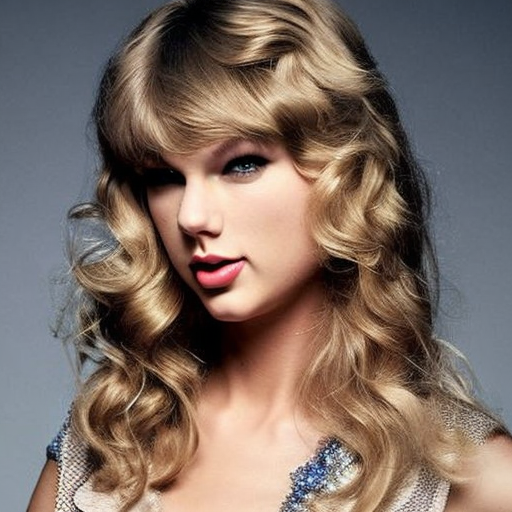

In [24]:
infer_and_show("A realistic high quality photo of taylor swift", seed=21, og_pipe=True)

experiments were made to make the model generate nice photos to compare. Stable Diffusion 2.1 is not 'that' good :d